In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings

import polars as pl
from matplotlib.ticker import PercentFormatter

# Create a cleaner and more intuitive environment for data analysis and graphing.

In [2]:
warnings.filterwarnings('ignore', category=FutureWarning)

sns.set(style="whitegrid")
%matplotlib inline

# Understanding the task


The aim of this competition is to predict the Severity Impairment Index (sii), which measures the level of problematic internet use among children and adolescents, based on physical activity data and other features.

sii is derived fro PCIAT-PCIAT_Totalal, the sum of scores from the Parent-Child Internet Addiction Test (PCIAT: 20 questions, scored 0-5).

# Data preview

In [3]:
season_dtype = pl.Enum(['Spring', 'Summer', 'Fall', 'Winter'])

train = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)

test = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)
data_dict = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv')

## Train data

In [4]:
display(train.head())
print(f"Train shape: {train.shape}")

id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,…,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
str,enum,i64,i64,enum,i64,enum,f64,f64,f64,f64,i64,i64,i64,enum,i64,i64,i64,enum,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,enum,i64,f64,f64,…,f64,f64,f64,f64,f64,enum,f64,enum,f64,enum,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,enum,i64,i64,enum,i64,i64
"""00008ff9""","""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,null,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,2.66855,16.8792,…,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,null,"""Fall""",5,4,4,0,4,0,0,4,0,0,4,0,4,4,4,4,4,4,2,4,55,null,null,null,"""Fall""",3,2
"""000fd460""","""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,22.0,75,70,122,null,null,null,null,"""Fall""",3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,2.57949,14.0371,…,21.0352,14.974,39.4497,15.4107,27.0552,null,null,"""Fall""",2.34,"""Fall""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""Fall""",46,64,"""Summer""",0,0
"""00105258""","""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,null,65,94,117,"""Fall""",5,7,33,"""Fall""",20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,…,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",5,2,2,1,2,1,1,2,1,1,1,0,1,1,1,0,2,2,1,1,28,"""Fall""",38,54,"""Summer""",2,0
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,…,30.4041,16.779,58.9338,26.4798,45.9966,null,null,"""Winter""",2.451,"""Summer""",4,2,4,0,5,1,0,3,2,2,3,0,3,0,0,3,4,3,4,1,44,"""Summer""",31,45,"""Winter""",0,1
"""0016bb22""","""Spring""",18,1,"""Summer""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,"""Summer""",1.04,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


Train shape: (3960, 82)


## Test data


In [5]:
display(test.head())
print(f"Test shape: {test.shape}")

id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
str,enum,i64,i64,enum,i64,enum,f64,f64,f64,f64,i64,i64,i64,enum,i64,i64,i64,enum,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,enum,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,enum,f64,enum,f64,enum,i64,i64,enum,i64
"""00008ff9""","""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,null,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,2.66855,16.8792,932.498,1492.0,8.25598,41.5862,13.8177,3.06143,9.21377,1,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,null,null,null,null,"""Fall""",3
"""000fd460""","""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,22.0,75,70,122,null,null,null,null,"""Fall""",3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1,21.0352,14.974,39.4497,15.4107,27.0552,null,null,"""Fall""",2.34,"""Fall""",46,64,"""Summer""",0
"""00105258""","""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,null,65,94,117,"""Fall""",5,7,33,"""Fall""",20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",38,54,"""Summer""",2
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,1131.43,1923.44,15.5925,62.7757,14.074,4.22033,18.8243,2,30.4041,16.779,58.9338,26.4798,45.9966,null,null,"""Winter""",2.451,"""Summer""",31,45,"""Winter""",0
"""0016bb22""","""Spring""",18,1,"""Summer""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Summer""",1.04,null,null,null,null,null,null,null


Test shape: (20, 59)


## Data dictionary

In [6]:
data_dict


,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
...,...,...,...,...,...,...
76,Sleep Disturbance Scale,SDS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
77,Sleep Disturbance Scale,SDS-SDS_Total_Raw,Total Raw Score,int,NaN,NaN
78,Sleep Disturbance Scale,SDS-SDS_Total_T,Total T-Score,int,NaN,NaN
79,Internet Use,PreInt_EduHx-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


Let's identify the features that are related to the target variable and that are not present in the test set.

In [7]:
train_cols = set(train.columns)
test_cols = set(test.columns)
columns_not_in_test = sorted(list(train_cols - test_cols))
data_dict[data_dict['Field'].isin(columns_not_in_test)]

,Instrument,Field,Description,Type,Values,Value Labels
54,Parent-Child Internet Addiction Test,PCIAT-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
55,Parent-Child Internet Addiction Test,PCIAT-PCIAT_01,How often does your child disobey time limits ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
56,Parent-Child Internet Addiction Test,PCIAT-PCIAT_02,How often does your child neglect household ch...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
57,Parent-Child Internet Addiction Test,PCIAT-PCIAT_03,How often does your child prefer to spend time...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
58,Parent-Child Internet Addiction Test,PCIAT-PCIAT_04,How often does your child form new relationshi...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
59,Parent-Child Internet Addiction Test,PCIAT-PCIAT_05,How often do you complain about the amount of ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
60,Parent-Child Internet Addiction Test,PCIAT-PCIAT_06,How often do your child's grades suffer becaus...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
61,Parent-Child Internet Addiction Test,PCIAT-PCIAT_07,How often does your child check his or her e-m...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
62,Parent-Child Internet Addiction Test,PCIAT-PCIAT_08,How often does your child seem withdrawn from ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
63,Parent-Child Internet Addiction Test,PCIAT-PCIAT_09,How often does your child become defensive or ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."


**Parent-Child Internet Addiction Test (PCIAT):** contains 20 items (`PCIAT-PCIAT_01` to `PCIAT-PCIAT_20`), each assessing a different aspect of a child's behavior related to internet use. The items are answered on a scale (from 0 to 5), and the total score provides an indication of the severity of internet addiction.

We also have season of participation in `PCIAT-Season` and total Score in `PCIAT-PCIAT_Total`; so there are 22 PCIAT test-related columns in total.

Let's verify that the `PCIAT-PCIAT_Total` align with the corresponding sii categories by calculating its minimum and maximum scores for each sii category:

In [8]:
train_tmp = train.to_pandas()
pciat_min_max = train_tmp.groupby('sii')['PCIAT-PCIAT_Total'].agg(['min', 'max'])
pciat_min_max = pciat_min_max.rename(
    columns={'min': 'Minimum PCIAT total Score', 'max': 'Maximum total PCIAT Score'}
)
display(pciat_min_max)
data_dict[data_dict['Field'] == 'PCIAT-PCIAT_Total']['Value Labels'].iloc[0]

,Minimum PCIAT total Score,Maximum total PCIAT Score
sii,,
0.0,0.0,30.0
1.0,31.0,49.0
2.0,50.0,79.0
3.0,80.0,93.0


'Severity Impairment Index: 0-30=None; 31-49=Mild; 50-79=Moderate; 80-100=Severe'

# Check NULL value

Let check missing value in `sii` column

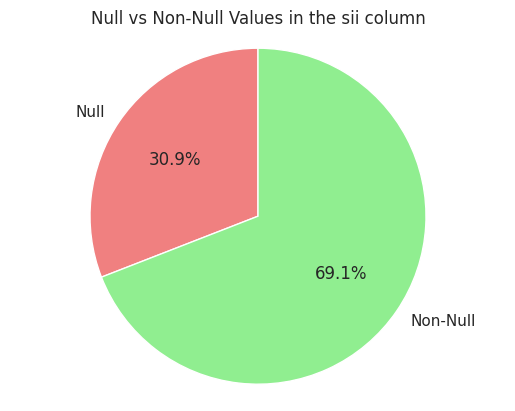

In [9]:
null_count = train.select(pl.col('sii').is_null().sum()).to_pandas().iloc[0, 0]  
non_null_count = len(train) - null_count  
# Vẽ biểu đồ tròn
labels = ['Null', 'Non-Null']
sizes = [null_count, non_null_count]
colors = ['lightcoral', 'lightgreen']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Null vs Non-Null Values in the sii column')
plt.axis('equal')  # Đảm bảo biểu đồ là tròn
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: We have 1/3 samples are missing sii target
</div>

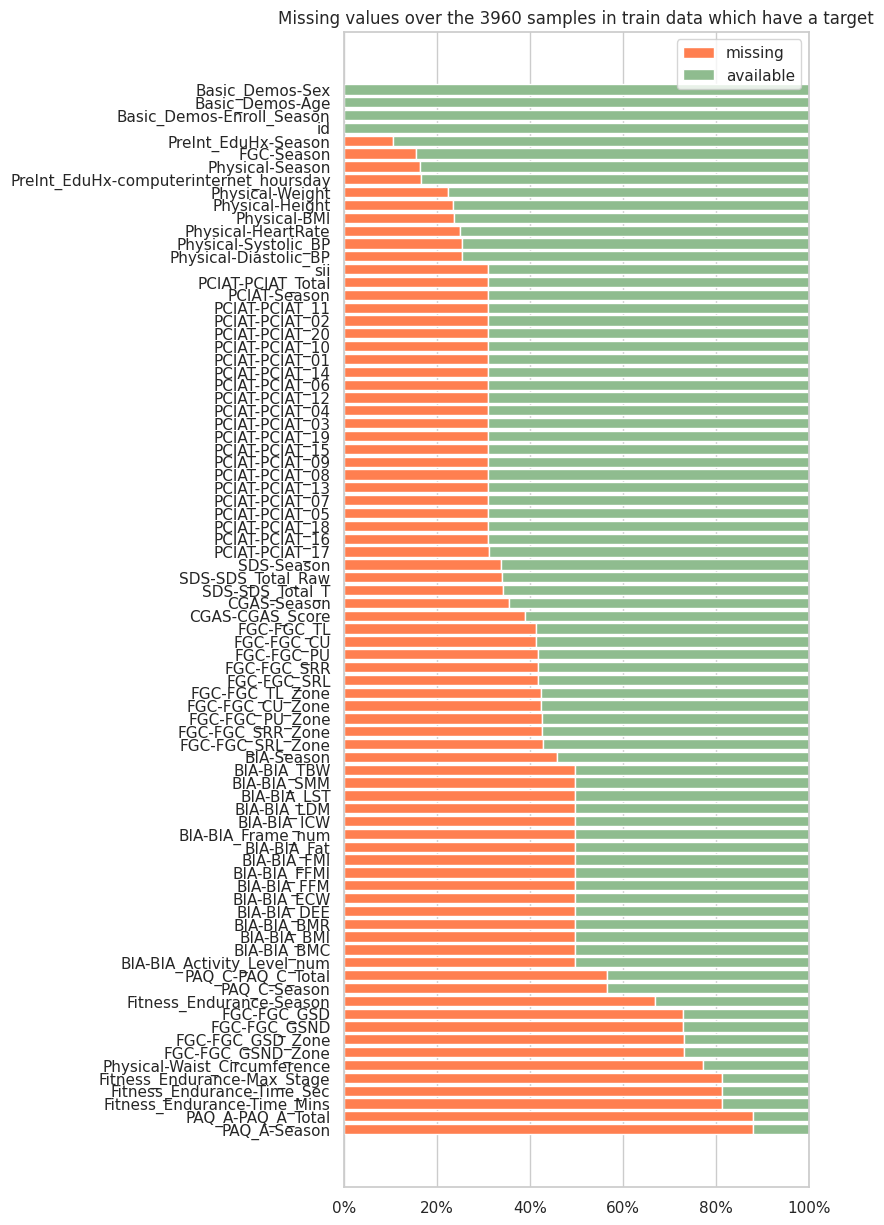

In [10]:
missing_count = (
    train
    .null_count()
    .transpose(include_header=True,
               header_name='feature',
               column_names=['null_count'])
    .sort('null_count', descending=True)
    .with_columns((pl.col('null_count') / len(train)).alias('null_ratio'))
)

plt.figure(figsize=(6, 15))
plt.title(f'Missing values over the {len(train)} samples in train data which have a target')
plt.barh(np.arange(len(missing_count)), missing_count.get_column('null_ratio'), color='coral', label='missing')
plt.barh(np.arange(len(missing_count)), 
         1 - missing_count.get_column('null_ratio'),
         left=missing_count.get_column('null_ratio'),
         color='darkseagreen', label='available')
plt.yticks(np.arange(len(missing_count)), missing_count.get_column('feature'))
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.legend()
plt.show()

In [11]:
missing_count['null_count'].sum() / (3960 * 82)

0.4056325449618133

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
💡 Note:
    
+ In General, a significant proportion of the data contains missing values, up to 40.5%.
    
+ Features with a high missing data rate:
    Some features, such as `Fitness_Endurance-Time_Mins` and `Fitness_Endurance-Time_Sec`, have a very high missing data rate, indicating there may be issues with the data collection process or that the data was not fully recorded for these cases. This may require the use of data imputation techniques or the removal of rows with missing data if recovery is not possible.

+ Features with a high availability of data:
    Features like `Basic_Demos-Age` or `PreInt_EduHx-computerinternet_hoursday` have a high availability of data, indicating that the quality of these features is good and they can be used directly in the model without requiring extensive handling of missing data. This also suggests that these features might be important factors in the data analysis.

+ Distribution of missing data:
Features with missing data spread evenly (i.e., not too many or too few missing values) indicate that missing data is not a global issue but is concentrated in a few parts of the dataset. This makes handling missing data easier, as these features do not require overly complex imputation strategies.

+ Analysis of relationships between features:
Some features have similar missing data rates (for example, those starting with `PCIAT`), which may indicate that they are related to a specific group of data or similar characteristics. Understanding the relationship between these features can help decide if data imputation can be done based on these relationships.

</div>

# Time series visualize

In [12]:
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import os
from tqdm import tqdm

def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df, filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    return stats, indexes

In [13]:
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

100%|██████████| 2/2 [00:00<00:00, 23.99it/s]


In [14]:
train_ts[0][1]

,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
0,0.239474,0.128193,-0.539177,0.092807,-42.693729,0.0,16.0,4143.000000,48000000000000,7,2,223.0
1,-0.168031,0.960363,-0.175933,0.057144,-10.230113,0.0,8.5,4142.333496,48005000000000,7,2,223.0
2,0.005663,0.925091,-0.345249,0.090669,-20.674137,0.0,26.0,4141.666504,48010000000000,7,2,223.0
3,0.638858,0.243702,-0.425669,0.079404,-28.251497,0.0,41.0,4141.000000,48015000000000,7,2,223.0
4,0.262944,0.273228,-0.796457,0.094136,-58.822552,0.0,11.5,4140.333496,48020000000000,7,2,223.0
...,...,...,...,...,...,...,...,...,...,...,...,...
340579,0.691592,0.324496,-0.625922,0.000000,-39.319786,0.0,6.0,3098.833252,22895000000000,6,2,243.0
340580,0.691734,0.324223,-0.626246,0.000004,-39.332798,0.0,6.0,3098.666748,22900000000000,6,2,243.0
340581,0.691863,0.324327,-0.626000,0.000000,-39.337654,0.0,6.0,3098.500000,22905000000000,6,2,243.0
340582,0.691540,0.324509,-0.625961,0.000000,-39.329155,0.0,6.0,3098.333252,22910000000000,6,2,243.0


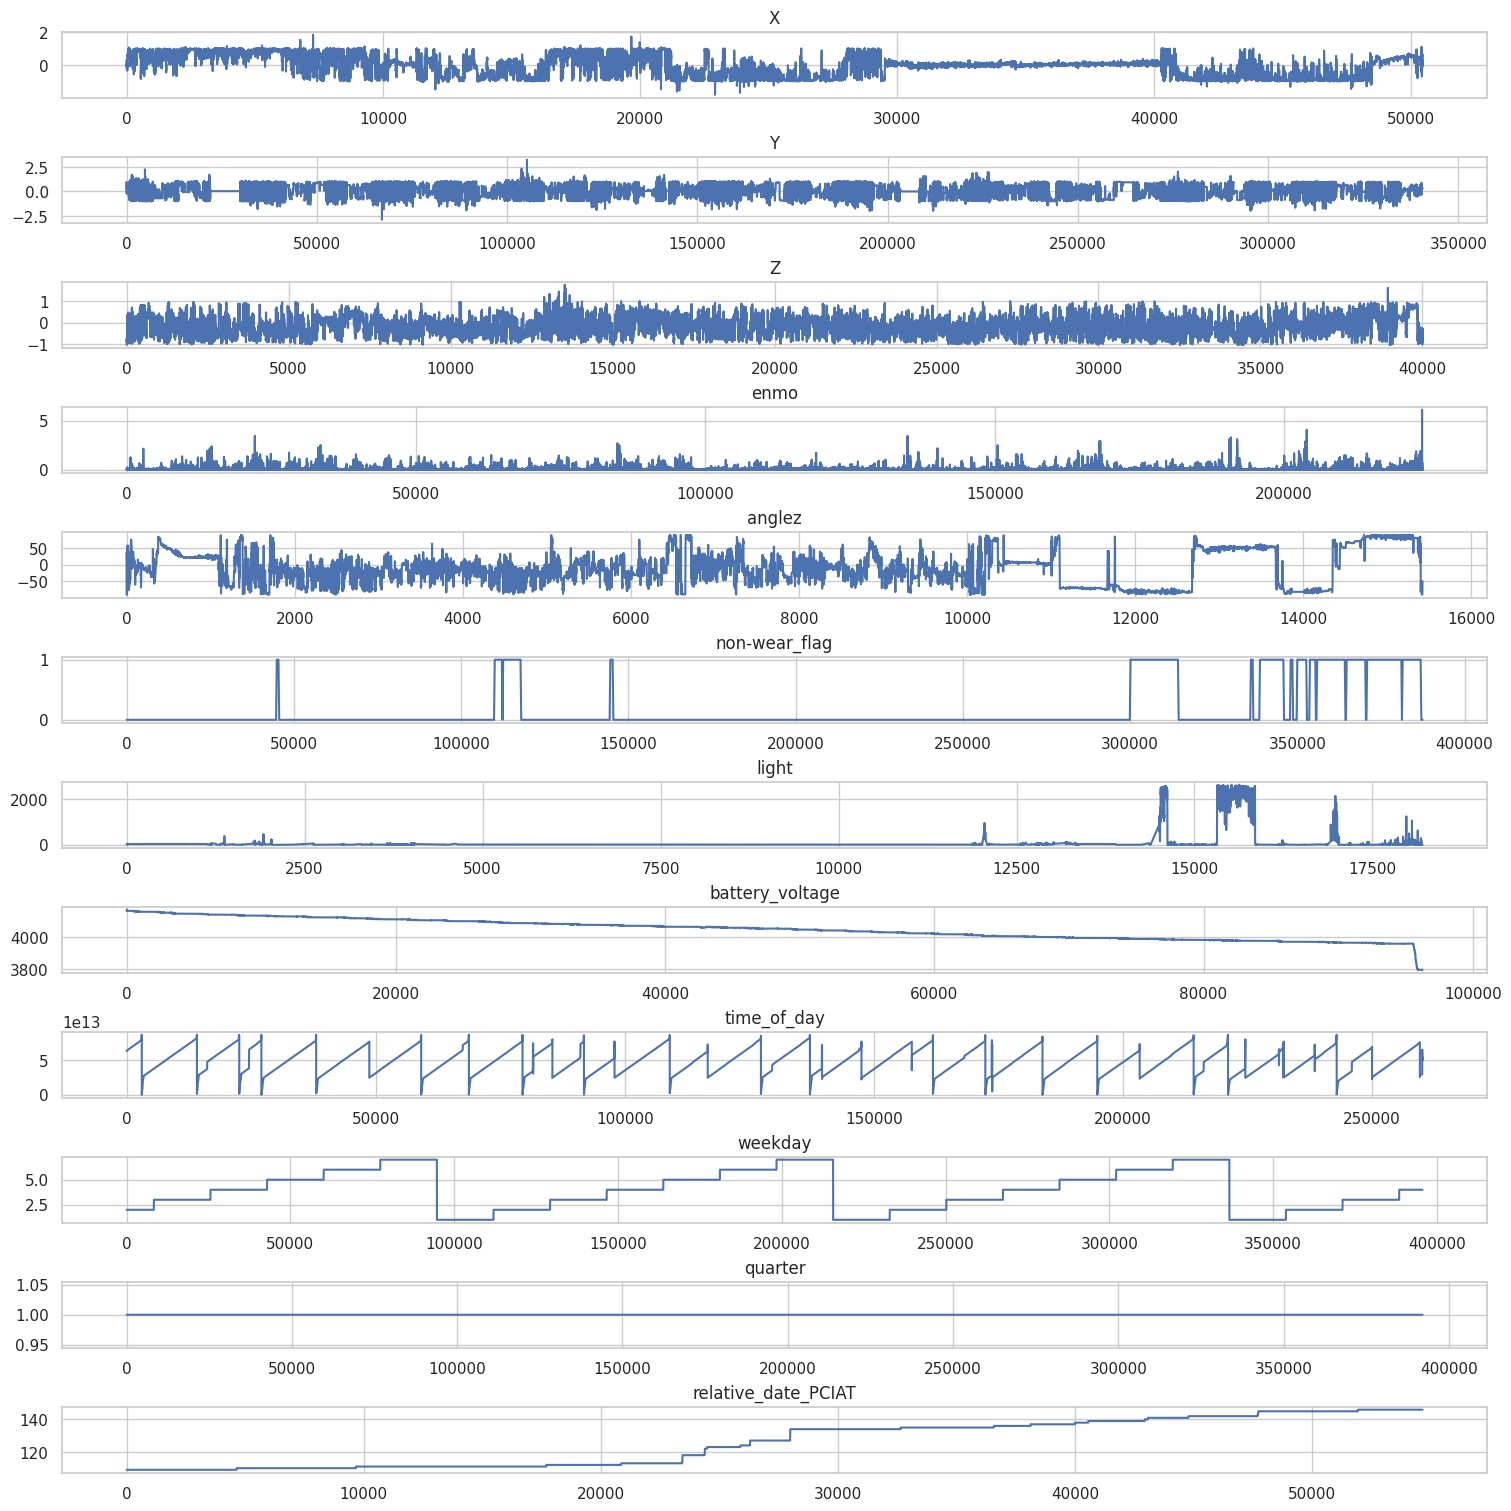

In [15]:
import matplotlib.pyplot as plt
import numpy as np

index = 5
fig, axis = plt.subplots(12, 1, constrained_layout = True)
fig.set_figwidth(15)
fig.set_figheight(15)

for index, col_name in enumerate(train_ts[0][index].columns):
    series = np.array(train_ts[0][index][col_name]);
    axis[index].plot(series)
    axis[index].set_title(col_name)

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
💡 Note: As we can see on the figure, number of timesteps is relatively long. With this long features, if we put it into a normal machine learning model, it will takes a huge amount of ram. Therefore we need to extract the most important information from the data. To do this, we can extract the basic information of the data and use it as input represent the whole file. 
</div>

In [16]:
train_ts[0][1].describe()

,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
count,340584.000000,340584.000000,340584.000000,340584.000000,340584.000000,340584.000000,340584.000000,340584.000000,3.405840e+05,340584.000000,340584.0,340584.000000
mean,0.113277,0.093139,-0.106038,0.028960,-6.065619,0.046508,56.437958,3829.466064,4.331149e+13,3.840885,2.0,232.909103
std,0.507897,0.541129,0.603787,0.096825,44.034721,0.208482,206.625092,167.600983,2.509136e+13,1.957999,0.0,5.701968
min,-1.807955,-2.887664,-1.004992,0.000000,-89.654587,0.000000,0.000000,3098.166748,0.000000e+00,1.000000,2.0,223.000000
25%,-0.231743,-0.257600,-0.595426,0.000367,-37.326844,0.000000,4.000000,3724.000000,2.128500e+13,2.000000,2.0,228.000000
50%,0.094074,0.068143,-0.228500,0.005257,-13.454103,0.000000,10.050480,3812.000000,4.360500e+13,4.000000,2.0,233.000000
75%,0.517859,0.542323,0.312333,0.020598,18.462269,0.000000,27.490936,3958.000000,6.511000e+13,5.000000,2.0,238.000000
max,1.928769,3.234613,2.475326,3.966906,89.080330,1.000000,2628.199951,4146.000000,8.639500e+13,7.000000,2.0,243.000000


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
💡 Note: After we plot basic information in the table, the number of features were small enough to be train. But the features is still contain lot of redundant information. To make it more pure to reduce overfitting, we can use an autoencoder to make it more compact.
</div>

# Check outlier

Lets draw some box plot!

In [17]:
train['Physical-BMI']

Physical-BMI
f64
16.877316
14.03559
16.648696
18.292347
null
…
16.36246
18.764678
21.4415


## Physical measures plot

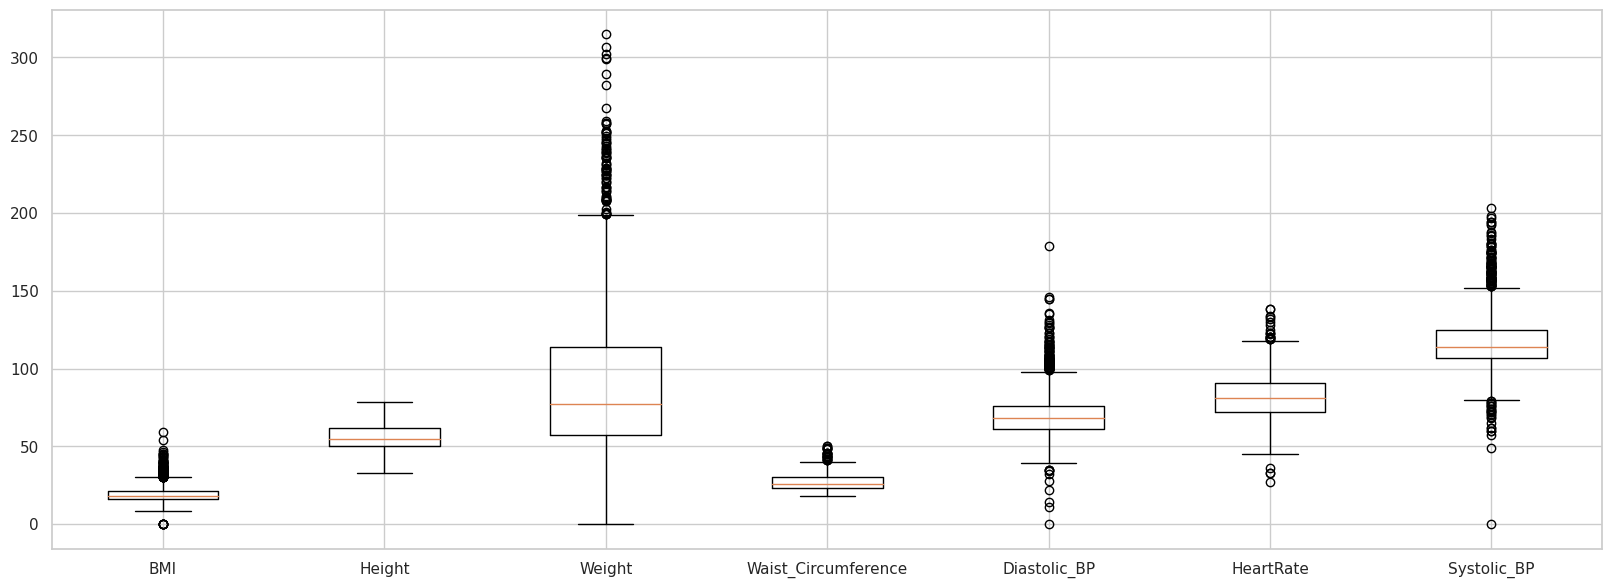

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def serialize(value):
    return pd.Series(value).dropna()
fig = plt.figure(figsize =(20, 7))

plt.boxplot([serialize(train['Physical-BMI']),
             serialize(train['Physical-Height']),
             serialize(train['Physical-Weight']),
             serialize(train['Physical-Waist_Circumference']),
             serialize(train['Physical-Diastolic_BP']),
             serialize(train['Physical-HeartRate']),
             serialize(train['Physical-Systolic_BP'])
            ],
           labels = ['BMI',
                     'Height', 
                     'Weight', 
                     'Waist_Circumference', 
                     'Diastolic_BP', 
                     'HeartRate',
                     'Systolic_BP'
                    ])

plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
💡 Note: From the plot above, we can see that there are some errors in many columns. 

+ First, Diastolic_BP represent the Diastolic Blood Pressure, BMI represent Body Mass Index and Systolic_BP represent Systolic Blood Pressure. These value is real value and often vary within a range, therefore can not be zero.
+ Second, Diastolic_BP follow this [link](https://www.verywellhealth.com/systolic-and-diastolic-blood-pressure-1746075) often fluctuate around 80. As we can see on the table above, there is a value around 180, which is too high. A normal person can not have Diastolic Blood Pressure so high like that.
</div>

## FitnessGram 

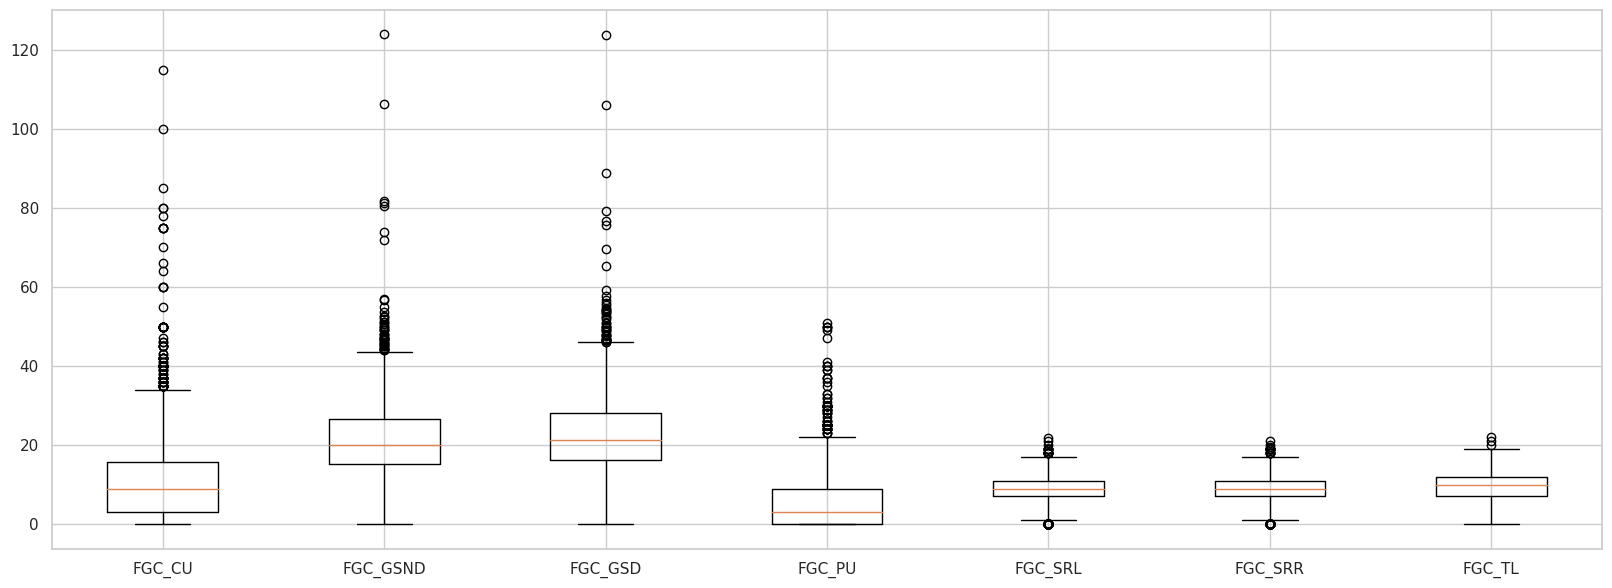

In [19]:
def serialize(value):
    return pd.Series(value).dropna()
fig = plt.figure(figsize =(20, 7))

plt.boxplot([serialize(train['FGC-FGC_CU']),
             serialize(train['FGC-FGC_GSND']),
             serialize(train['FGC-FGC_GSD']),
             serialize(train['FGC-FGC_PU']),
             serialize(train['FGC-FGC_SRL']),
             serialize(train['FGC-FGC_SRR']),
             serialize(train['FGC-FGC_TL'])
            ],
           labels = ['FGC_CU',
                     'FGC_GSND', 
                     'FGC_GSD', 
                     'FGC_PU', 
                     'FGC_SRL', 
                     'FGC_SRR',
                     'FGC_TL'
                    ])

plt.show()

Nothing special here, lets draw it for children.

In [20]:
train.head()

id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,…,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
str,enum,i64,i64,enum,i64,enum,f64,f64,f64,f64,i64,i64,i64,enum,i64,i64,i64,enum,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,enum,i64,f64,f64,…,f64,f64,f64,f64,f64,enum,f64,enum,f64,enum,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,enum,i64,i64,enum,i64,i64
"""00008ff9""","""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,null,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,2.66855,16.8792,…,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,null,"""Fall""",5,4,4,0,4,0,0,4,0,0,4,0,4,4,4,4,4,4,2,4,55,null,null,null,"""Fall""",3,2
"""000fd460""","""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,22.0,75,70,122,null,null,null,null,"""Fall""",3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,2.57949,14.0371,…,21.0352,14.974,39.4497,15.4107,27.0552,null,null,"""Fall""",2.34,"""Fall""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""Fall""",46,64,"""Summer""",0,0
"""00105258""","""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,null,65,94,117,"""Fall""",5,7,33,"""Fall""",20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,…,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",5,2,2,1,2,1,1,2,1,1,1,0,1,1,1,0,2,2,1,1,28,"""Fall""",38,54,"""Summer""",2,0
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,…,30.4041,16.779,58.9338,26.4798,45.9966,null,null,"""Winter""",2.451,"""Summer""",4,2,4,0,5,1,0,3,2,2,3,0,3,0,0,3,4,3,4,1,44,"""Summer""",31,45,"""Winter""",0,1
"""0016bb22""","""Spring""",18,1,"""Summer""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,"""Summer""",1.04,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


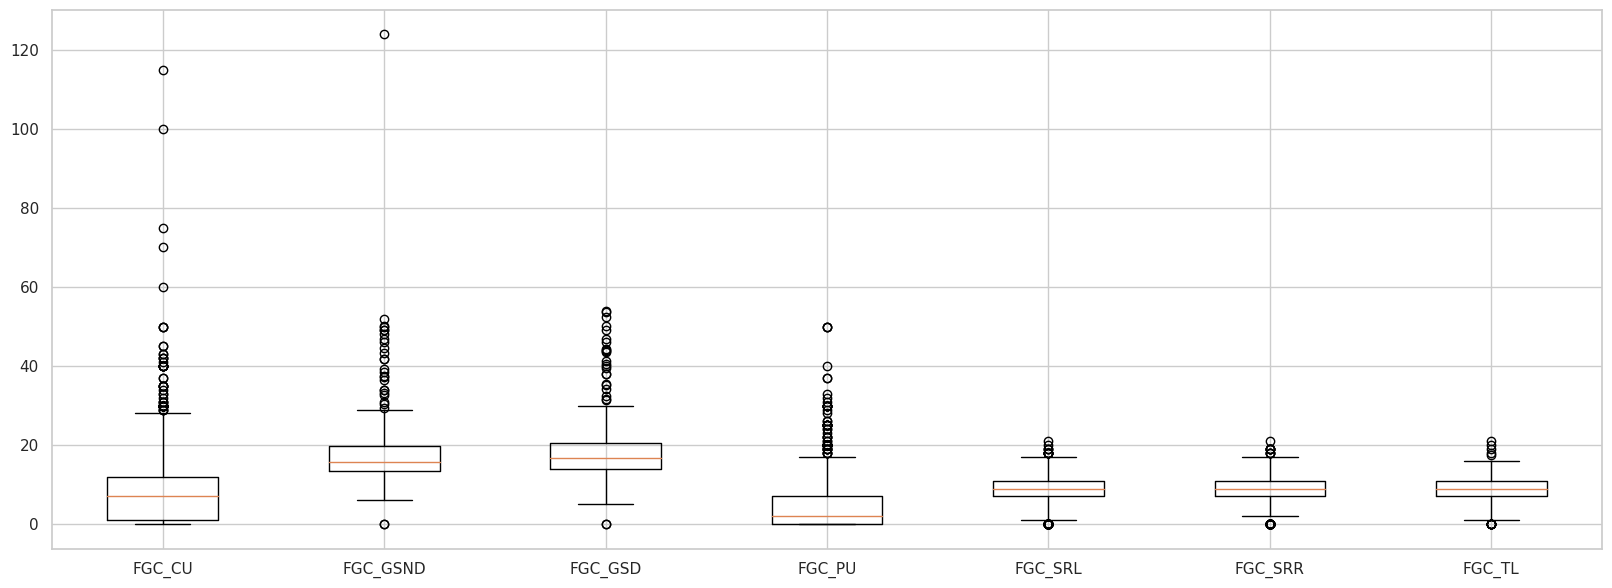

In [21]:
fig = plt.figure(figsize =(20, 7))
plt.boxplot([serialize(train.filter(train['Basic_Demos-Age'] <= 12)['FGC-FGC_CU']),
             serialize(train.filter(train['Basic_Demos-Age'] <= 12)['FGC-FGC_GSND']),
             serialize(train.filter(train['Basic_Demos-Age'] <= 12)['FGC-FGC_GSD']),
             serialize(train.filter(train['Basic_Demos-Age'] <= 12)['FGC-FGC_PU']),
             serialize(train.filter(train['Basic_Demos-Age'] <= 12)['FGC-FGC_SRL']),
             serialize(train.filter(train['Basic_Demos-Age'] <= 12)['FGC-FGC_SRR']),
             serialize(train.filter(train['Basic_Demos-Age'] <= 12)['FGC-FGC_TL'])
            ],
           labels = ['FGC_CU',
                     'FGC_GSND', 
                     'FGC_GSD', 
                     'FGC_PU', 
                     'FGC_SRL', 
                     'FGC_SRR',
                     'FGC_TL'
                    ])
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
💡 Note: From the plot above, we can see that there are some errors in many columns. 

+ The child from 5-12 can not curl up to 100 or around 115. These values should be more reasonable for adult. But there may happen a situation that the childs have been training their muscle since they were really little, we just dont know. 

+ Similarly, Grip Strength total have a weird outlier (more than 120). There is a high chance that this value is error of the device or human error.

</div>

## Bio-electric Impedance Analysis

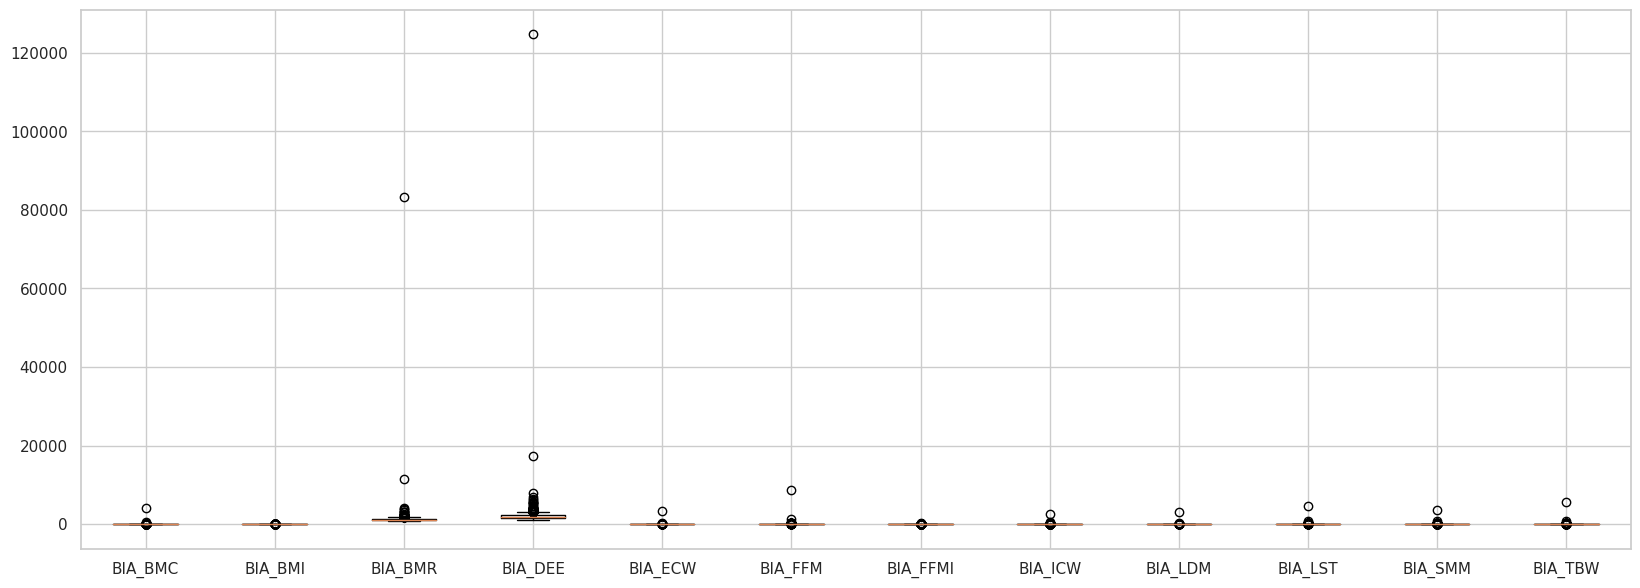

In [22]:
fig = plt.figure(figsize =(20, 7))
plt.boxplot([serialize(train['BIA-BIA_BMC']),
             serialize(train['BIA-BIA_BMI']),
             serialize(train['BIA-BIA_BMR']),
             serialize(train['BIA-BIA_DEE']),
             serialize(train['BIA-BIA_ECW']),
             serialize(train['BIA-BIA_FFM']),
             serialize(train['BIA-BIA_FFMI']),
             serialize(train['BIA-BIA_ICW']),
             serialize(train['BIA-BIA_LDM']),
             serialize(train['BIA-BIA_LST']),
             serialize(train['BIA-BIA_SMM']),
             serialize(train['BIA-BIA_TBW'])
            ],
           labels = ['BIA_BMC',
                     'BIA_BMI', 
                     'BIA_BMR', 
                     'BIA_DEE', 
                     'BIA_ECW', 
                     'BIA_FFM',
                     'BIA_FFMI',
                     'BIA_ICW',
                     'BIA_LDM',
                     'BIA_LST',
                     'BIA_SMM',
                     'BIA_TBW'
                    ])

plt.show()

Remove outlier to make is more interpreterable

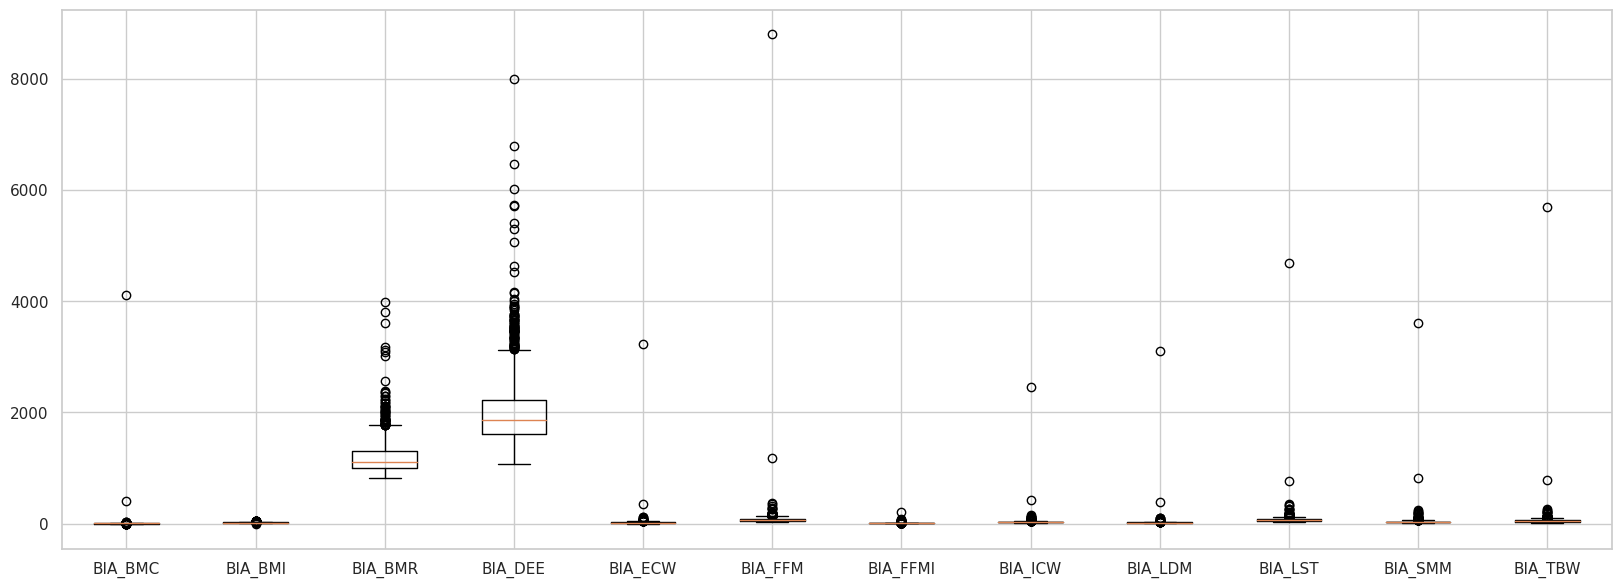

In [23]:
fig = plt.figure(figsize =(20, 7))
plt.boxplot([serialize(train['BIA-BIA_BMC']),
             serialize(train['BIA-BIA_BMI']),
             serialize(train.filter(train['BIA-BIA_BMR'] < 10000)['BIA-BIA_BMR']),
             serialize(train.filter(train['BIA-BIA_DEE'] < 10000)['BIA-BIA_DEE']),
             serialize(train['BIA-BIA_ECW']),
             serialize(train['BIA-BIA_FFM']),
             serialize(train['BIA-BIA_FFMI']),
             serialize(train['BIA-BIA_ICW']),
             serialize(train['BIA-BIA_LDM']),
             serialize(train['BIA-BIA_LST']),
             serialize(train['BIA-BIA_SMM']),
             serialize(train['BIA-BIA_TBW'])
            ],
           labels = ['BIA_BMC',
                     'BIA_BMI', 
                     'BIA_BMR', 
                     'BIA_DEE', 
                     'BIA_ECW', 
                     'BIA_FFM',
                     'BIA_FFMI',
                     'BIA_ICW',
                     'BIA_LDM',
                     'BIA_LST',
                     'BIA_SMM',
                     'BIA_TBW'
                    ])

plt.show()

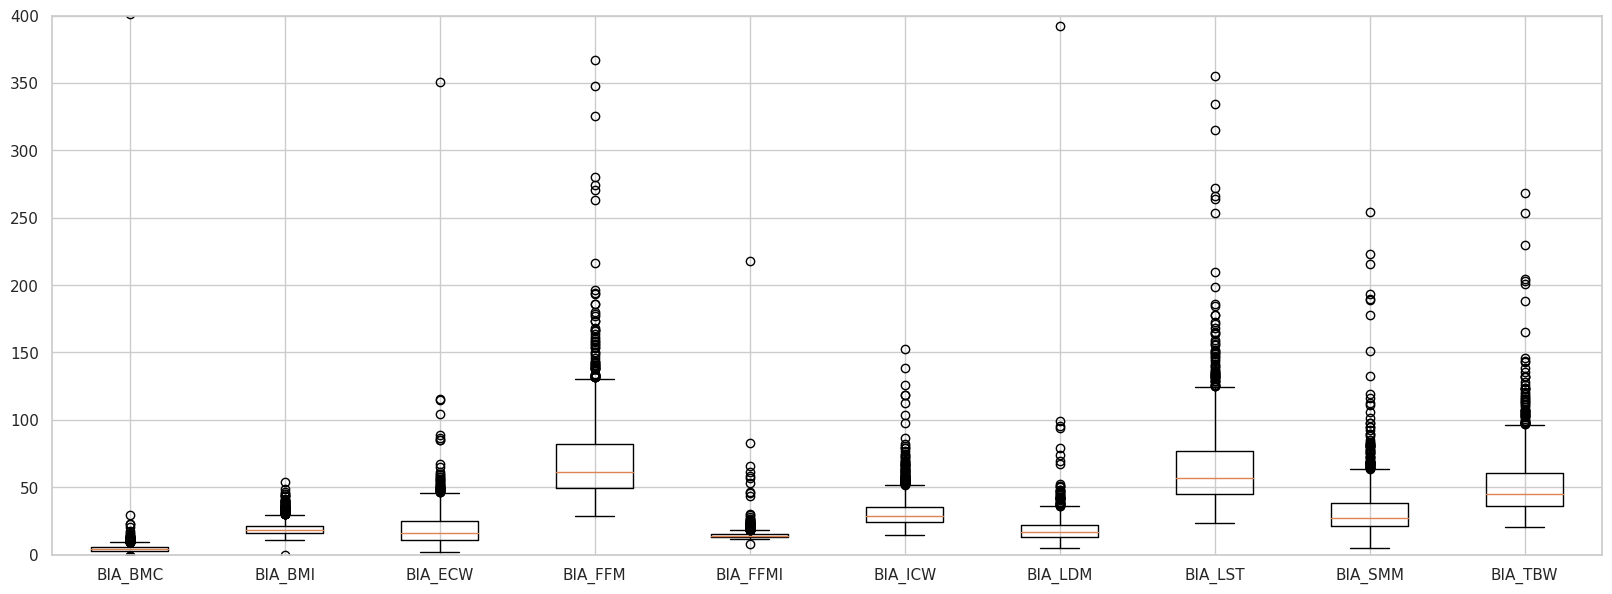

In [24]:
fig = plt.figure(figsize =(20, 7))
plt.boxplot([serialize(train['BIA-BIA_BMC']),
             serialize(train['BIA-BIA_BMI']),
             serialize(train['BIA-BIA_ECW']),
             serialize(train['BIA-BIA_FFM']),
             serialize(train['BIA-BIA_FFMI']),
             serialize(train['BIA-BIA_ICW']),
             serialize(train['BIA-BIA_LDM']),
             serialize(train['BIA-BIA_LST']),
             serialize(train['BIA-BIA_SMM']),
             serialize(train['BIA-BIA_TBW'])
            ],
           labels = ['BIA_BMC',
                     'BIA_BMI', 
                     'BIA_ECW', 
                     'BIA_FFM',
                     'BIA_FFMI',
                     'BIA_ICW',
                     'BIA_LDM',
                     'BIA_LST',
                     'BIA_SMM',
                     'BIA_TBW'
                    ])
plt.ylim([0, 400])
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
💡 Note: From the plot above, we can see that there are a lot of outlier that far beyond the rest. No human can have these values. Therefore cut down these values to train is necessary.

</div>

# Check data distribution to serve for normalize

Filtering columns in both train and test dataset and is not categorical int, str, categorical and visualize these

In [25]:
import numpy as np
import polars as pl
import pandas as pd
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
numeric_cols = []
for col in test.columns:
    unique_values = train[col].nunique()
    if unique_values > 6 and not pd.api.types.is_string_dtype(train[col]) and col != "PCIAT-PCIAT_Total":
        numeric_cols.append(col)
print("Numeric Columns:", numeric_cols)

Numeric Columns: ['Basic_Demos-Age', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T']


In [26]:
min_values = train[numeric_cols].min()
max_values = train[numeric_cols].max()

summary_table = pd.DataFrame({
    'Feature': numeric_cols,
    'Min': min_values.values,
    'Max': max_values.values
})

print(summary_table)

                         Feature          Min            Max
0                Basic_Demos-Age     5.000000      22.000000
1                CGAS-CGAS_Score    25.000000     999.000000
2                   Physical-BMI     0.000000      59.132048
3                Physical-Height    33.000000      78.500000
4                Physical-Weight     0.000000     315.000000
5   Physical-Waist_Circumference    18.000000      50.000000
6          Physical-Diastolic_BP     0.000000     179.000000
7             Physical-HeartRate    27.000000     138.000000
8           Physical-Systolic_BP     0.000000     203.000000
9    Fitness_Endurance-Max_Stage     0.000000      28.000000
10   Fitness_Endurance-Time_Mins     0.000000      20.000000
11    Fitness_Endurance-Time_Sec     0.000000      59.000000
12                    FGC-FGC_CU     0.000000     115.000000
13                  FGC-FGC_GSND     0.000000     124.000000
14                   FGC-FGC_GSD     0.000000     123.800000
15                    FG

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    
💡 Note: From the summary table above we have seen that:
+ The range of values varies significantly between columns. Some columns have a very large range of values, while others have a small range. For example: `BIA-BIA_BMR` (813.397000 to 83152.200000) → large range, `Physical-HeartRate` (27.000000 to 138.000000) → small range, `BIA-BIA_Fat` (-8745.080000 to 153.820000) → values include both negative and positive.
+ Negative and positive values exist within the same dataset. Some columns, such as `BIA-BIA_BMC` and `BIA-BIA_Fat`, contain both negative and positive values. This can cause the data to become skewed if not normalized.
</div>

# Redundant Features

To begin, the dataset provided by the competition will be reloaded for processing. The first step involves identifying **column sii with missing values** and marking them as **"missing"** in the dataset. These identified missing values will then be **converted into numerical** representations for consistency. Subsequently, the feature named "Season" will be removed from the dataset as it is deemed unnecessary for further analysis.

Next, a correlation heatmap will be generated to analyze the relationship between each feature and the target variable "sii" in the training set. This visualization will provide insights into how strongly each feature correlates with "sii," enabling better feature selection and further preprocessing.

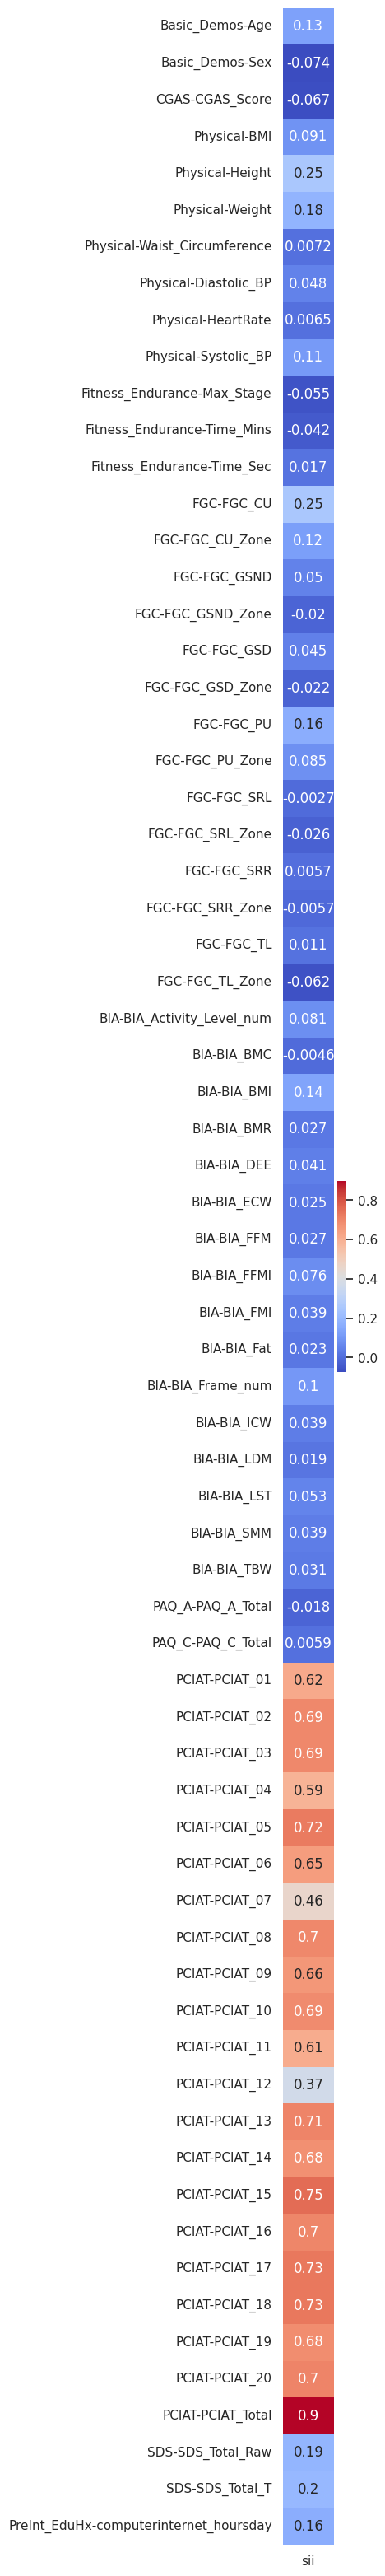

In [27]:
import numpy as np
import polars as pl
import pandas as pd
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')

sii_map = {0: '0 (None)', 1: '1 (Mild)', 2: '2 (Moderate)', 3: '3 (Severe)'}
train['sii'] = train['sii'].map(sii_map).fillna('Missing')
sii_order = ['Missing', '0 (None)', '1 (Mild)', '2 (Moderate)', '3 (Severe)']
train['sii'] = pd.Categorical(train['sii'], categories=sii_order, ordered=True)

train_engineer = train
train_engineer['sii'] = train['sii'].cat.codes

season_cols = [col for col in train_engineer.columns if train_engineer[col].dtype == 'object']
train_engineer = train_engineer.drop(season_cols, axis=1)

corr_matrix_sii = train_engineer.corr()['sii'].drop('sii')
corr_df_sii = pd.DataFrame(corr_matrix_sii)
plt.figure(figsize=(1,40))
sns.heatmap(corr_df_sii, annot=True, cmap='coolwarm')
plt.show()

Next, a **correlation heatmap** will be plotted for **all features** provided in the training dataset. This visualization will allow for a comprehensive analysis of the relationships between features, identifying any strong positive or negative correlations among them. By observing these correlations, potential multicollinearity issues can be detected, which is essential for feature selection and improving model performance.

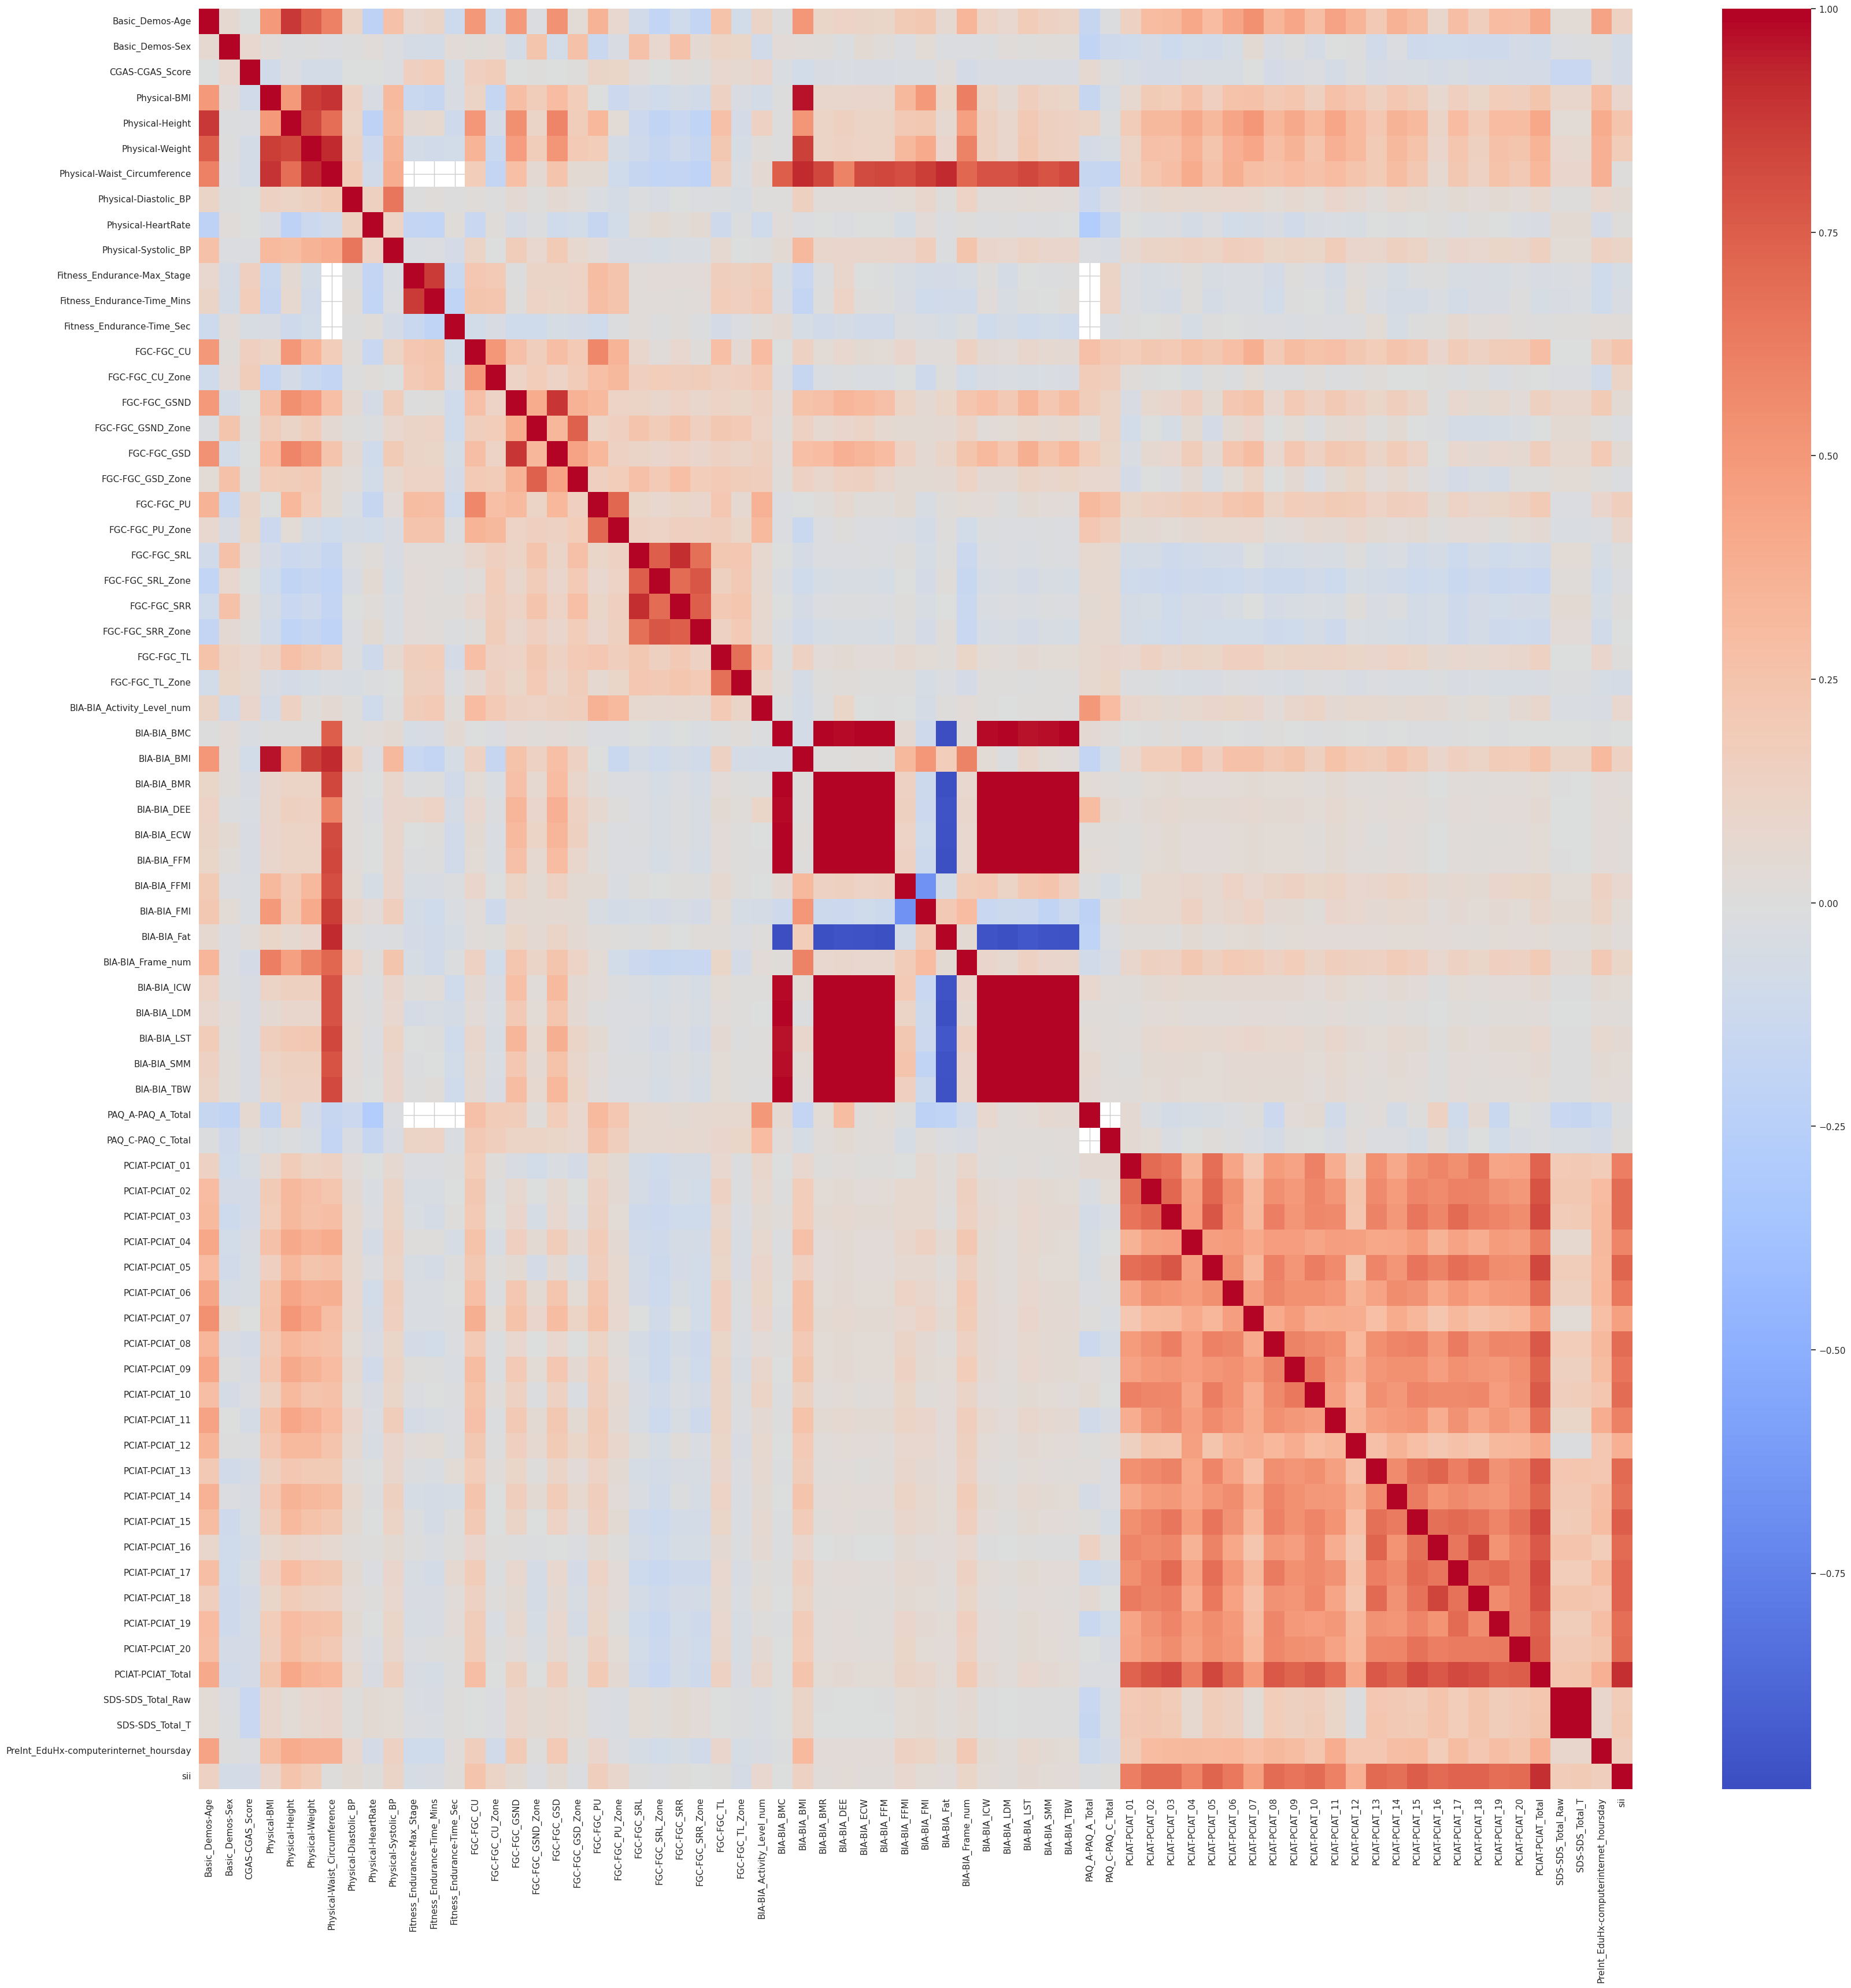

In [28]:
corr_matrix = train_engineer.corr()
plt.figure(figsize=(40,40))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm',center = 0)
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;">
💡 Note: From the correlation analysis, we have observed that:

Features in the Physical, BIA, and FGC groups exhibit strong interrelations. Therefore, a correlation heatmap for these three feature groups will be generated for further analysis.
So set individual thresholds for each feature group and remove unnecessary columns accordingly. (keeping only one feature within a correlated group while retaining the necessary information for training)

</div>

## Physical

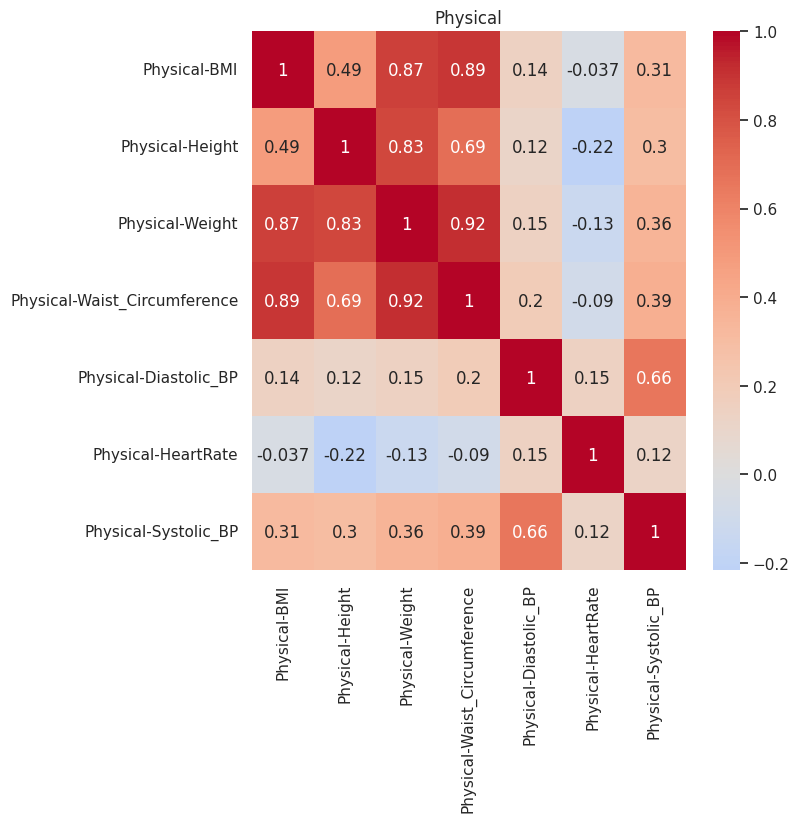

In [29]:
physical_cols = [col for col in train_engineer.columns if 'Physical' in col]
corr_matrix_physical = train_engineer[physical_cols].corr()[physical_cols]
plt.figure(figsize=(7,7))
sns.heatmap(corr_matrix_physical, annot=True, cmap='coolwarm', center = 0)
plt.title("Physical")
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;">
💡 Note: From the heatmap, we observe that BMI, Height, Weight, and Waist exhibit high correlation (greater than 0.5).


* The most reasonable approach is to retain Height and Weight while removing BMI and Waist. This is because BMI and Waist can be derived directly from Height and Weight, and their pairwise correlation is also very high.


</div>

## FGC

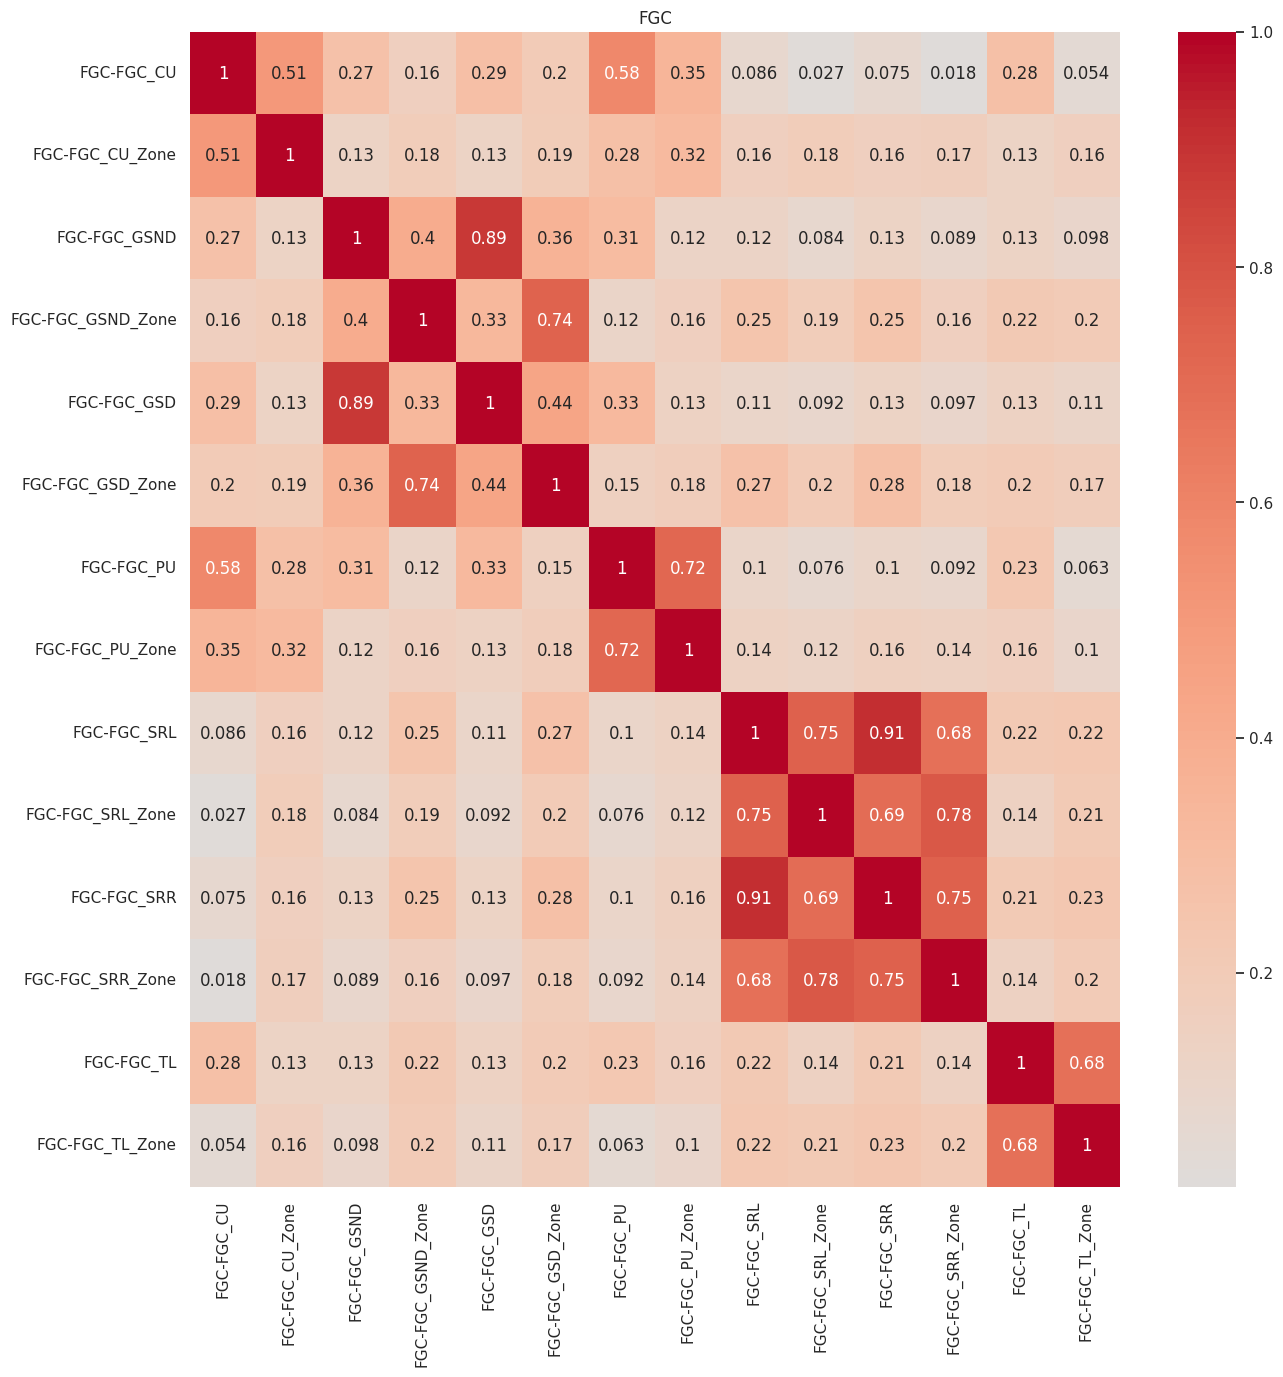

In [30]:
FGC_cols = [col for col in train_engineer.columns if 'FGC' in col]
corr_matrix_FGC = train_engineer[FGC_cols].corr()[FGC_cols]
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix_FGC, annot=True, cmap='coolwarm', center = 0)
plt.title("FGC")
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;">
💡 Note: At this stage, we will not remove any columns from this group of features because their correlations remain relatively stable (around 0.5). Keeping these features intact ensures that no potentially valuable information is lost during the training process.

</div>

## BIA

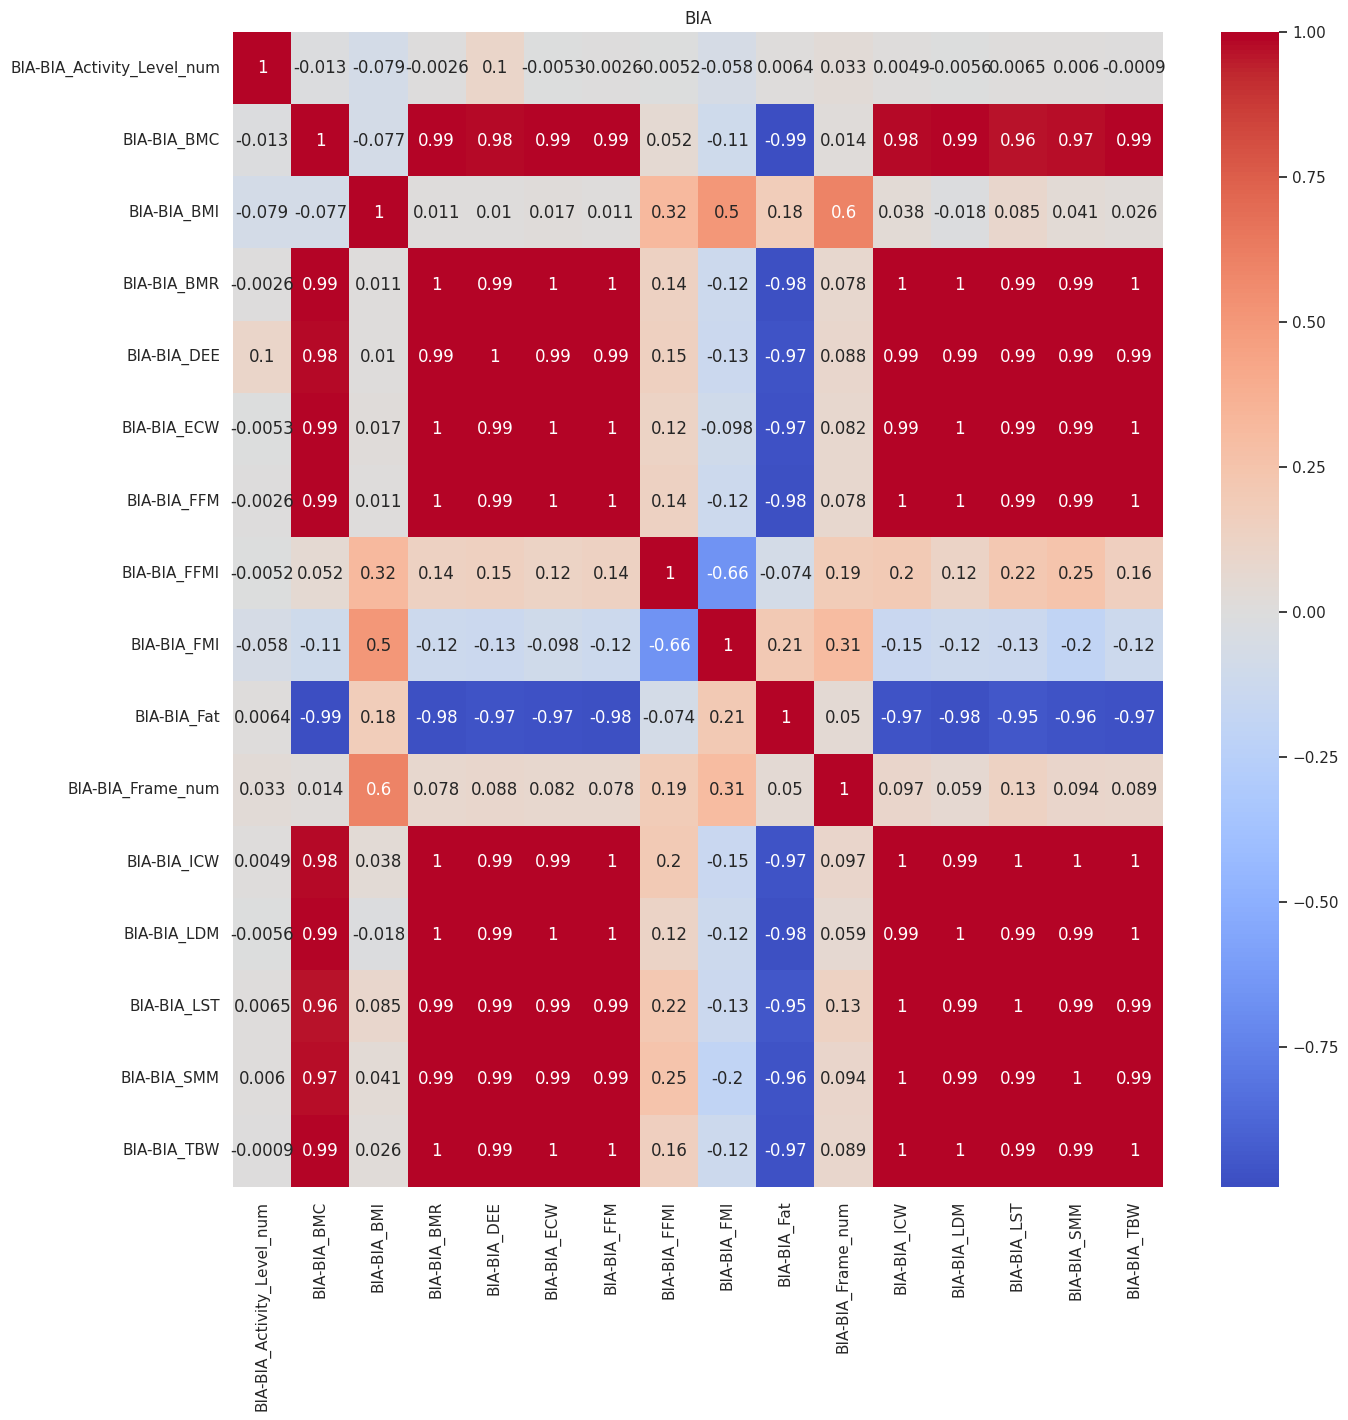

In [31]:
BIA_cols = [col for col in train_engineer.columns if 'BIA' in col]
corr_matrix_BIA = train_engineer[BIA_cols].corr()[BIA_cols]
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix_BIA, annot=True, cmap='coolwarm', center = 0)
plt.title("BIA")
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;">
💡 Note: Based on the heatmap analysis, we will retain the following groups of columns:


* BIA-BIA_Activity_Level_num
* BIA-BIA_BMC
* BIA-BIA_BMI
* BIA-BIA_FFM
* BIA-BIA_FFMI
* BIA-BIA_FMI
* BIA-BIA_Fat

These features are selected as they exhibit meaningful relationships with other variables while maintaining valuable information for the training process.

</div>